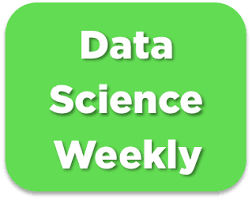

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Read file with labels

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

## Training pipeline

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)
mask = data["age"] < 80
data = data[mask]

features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'
numeric_indices = [1,3]
categorical_indices = [0,2]

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)

numeric_features = ['age', 'total_pages_visited']  # Names of numeric columns in X_train/X_test

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # standardization
])

categorical_features = ['country', 'new_user', 'source']  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(drop='first'))
        # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Set with labels (our train+test) : (284580, 6)


In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

print("Grid search...")

sgdc = SGDClassifier()

loss = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
penalty = ['l2', 'elasticnet']
alpha = [0.00000001, 0.0000001, 0.00000000001, 0.1]
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
# class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

param_distributions = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha,
                           learning_rate=learning_rate,
                           # class_weight=class_weight,
                           eta0=eta0)
# >
while True:
    gridsearch_sgdc = RandomizedSearchCV(sgdc, param_distributions=param_distributions, cv=5, scoring="f1", n_jobs=-1)
                                      # verbose=True)  # cv : the number of folds to be used for CV
    gridsearch_sgdc.fit(X_train, Y_train)
    print("...Done.")

    print("Accuracy on training set : ", gridsearch_sgdc.score(X_train, Y_train))
    print("Accuracy on test set : ", gridsearch_sgdc.score(X_test, Y_test))

    # Predictions on training set
    Y_train_pred = gridsearch_sgdc.predict(X_train)
    Y_test_pred = gridsearch_sgdc.predict(X_test)


    print("Best hyperparameters : ", gridsearch_sgdc.best_params_)
    print("Best validation accuracy : ", gridsearch_sgdc.best_score_)

    print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
    print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
    # f1-score on train set :  0.7678455758517944
    # f1-score on test set :  0.769855072463768

    # Concatenate our train and test set to train your best classifier on all data with labels

    X = np.append(X_train, X_test, axis=0)
    Y = np.append(Y_train, Y_test)

    gridsearch_sgdc.best_estimator_.fit(X, Y)

    pred = gridsearch_sgdc.best_estimator_.predict(X)
    print("f1-score on set : ", f1_score(Y, pred))
    a1 = f1_score(Y_train, Y_train_pred)
    a2 = f1_score(Y_test, Y_test_pred)
    a3 = f1_score(Y, pred)
    # if a1, a2 and a3 are superior to 0.77

    # create a file named randomsearch.txt and store the results
    with open("randomsearch.txt", "a") as f:
        f.write("f1-score on train set : " + str(a1) + "\n")
        f.write("f1-score on test set : " + str(a2) + "\n")
        f.write("f1-score on set : " + str(a3) + "\n")
        f.write("Best hyperparameters : " + str(gridsearch_sgdc.best_params_) + "\n")
        f.write("Best validation accuracy : " + str(gridsearch_sgdc.best_score_) + "\n")
        f.write("Accuracy on training set : " + str(gridsearch_sgdc.score(X_train, Y_train)) + "\n")
        f.write("Accuracy on test set : " + str(gridsearch_sgdc.score(X_test, Y_test)) + "\n")
        f.write("---------------------")

    if a1 > 0.77 and a2 > 0.77 and a3 > 0.77:
        print("found")
        break

Grid search...
...Done.
Accuracy on training set :  0.7630855840761344
Accuracy on test set :  0.7723723723723724
Best hyperparameters :  {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'adaptive', 'eta0': 1, 'alpha': 1e-07}
Best validation accuracy :  0.7631934767594089
f1-score on train set :  0.7630855840761344
f1-score on test set :  0.7723723723723724
f1-score on set :  0.7640462985290571
...Done.
Accuracy on training set :  0.7637482374054608
Accuracy on test set :  0.7627215551743854
Best hyperparameters :  {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'invscaling', 'eta0': 100, 'alpha': 1e-08}
Best validation accuracy :  0.7628177384810781
f1-score on train set :  0.7637482374054608
f1-score on test set :  0.7627215551743854
f1-score on set :  0.7636559655007188
...Done.
Accuracy on training set :  0.7644013804088133
Accuracy on test set :  0.7697798929208804
Best hyperparameters :  {'penalty': 'elasticnet', 'loss': 'squared_hinge', 'learning_rate': 'invscaling'

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning

...Done.
Accuracy on training set :  0.6973624717407686
Accuracy on test set :  0.7065948855989233
Best hyperparameters :  {'penalty': 'l2', 'loss': 'squared_hinge', 'learning_rate': 'invscaling', 'eta0': 10, 'alpha': 0.01}
Best validation accuracy :  0.753809479184852
f1-score on train set :  0.6973624717407686
f1-score on test set :  0.7065948855989233
f1-score on set :  0.7476534943504514
...Done.
Accuracy on training set :  0.7501914108721376
Accuracy on test set :  0.7524752475247525
Best hyperparameters :  {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'invscaling', 'eta0': 100, 'alpha': 1e-07}
Best validation accuracy :  0.7662606498741629
f1-score on train set :  0.7501914108721376
f1-score on test set :  0.7524752475247525
f1-score on set :  0.760843227526048
...Done.
Accuracy on training set :  0.7346069171223635
Accuracy on test set :  0.7389100126742714
Best hyperparameters :  {'penalty': 'l2', 'loss': 'squared_hinge', 'learning_rate': 'adaptive', 'eta0': 10, 'alpha

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning

...Done.
Accuracy on training set :  0.7591112315404417
Accuracy on test set :  0.7662416514875532
Best hyperparameters :  {'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 10, 'alpha': 1e-08}
Best validation accuracy :  0.7587335900727187
f1-score on train set :  0.7591112315404417
f1-score on test set :  0.7662416514875532
f1-score on set :  0.7601876104038496
...Done.
Accuracy on training set :  0.7592981505318068
Accuracy on test set :  0.7662416514875532
Best hyperparameters :  {'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 10, 'alpha': 1e-07}
Best validation accuracy :  0.7586479604451452
f1-score on train set :  0.7592981505318068
f1-score on test set :  0.7662416514875532
f1-score on set :  0.7595168374816983
...Done.
Accuracy on training set :  0.735677821894498
Accuracy on test set :  0.7413029728020241
Best hyperparameters :  {'penalty': 'l2', 'loss': 'modified_huber', 'learning_rate': 'adaptive', 'eta0': 10, 'alpha': 0.01}
Best

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning

...Done.
Accuracy on training set :  0.7685934612198074
Accuracy on test set :  0.7638019351166762
Best hyperparameters :  {'penalty': 'l2', 'loss': 'squared_hinge', 'learning_rate': 'invscaling', 'eta0': 10, 'alpha': 1e-07}
Best validation accuracy :  0.7617139664567505
f1-score on train set :  0.7685934612198074
f1-score on test set :  0.7638019351166762
f1-score on set :  0.7655832194426289


/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning

...Done.
Accuracy on training set :  0.7703043225431285
Accuracy on test set :  0.7682502896871378
Best hyperparameters :  {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'invscaling', 'eta0': 10, 'alpha': 1e-08}
Best validation accuracy :  0.7606510041361035
f1-score on train set :  0.7703043225431285
f1-score on test set :  0.7682502896871378
f1-score on set :  0.7627435603547084
...Done.
Accuracy on training set :  0.757265656979124
Accuracy on test set :  0.7593386405388854
Best hyperparameters :  {'penalty': 'l2', 'loss': 'squared_hinge', 'learning_rate': 'adaptive', 'eta0': 1, 'alpha': 1e-08}
Best validation accuracy :  0.7571577854154793
f1-score on train set :  0.757265656979124
f1-score on test set :  0.7593386405388854
f1-score on set :  0.7578340589930704
...Done.
Accuracy on training set :  0.7632759659813835
Accuracy on test set :  0.7723723723723724
Best hyperparameters :  {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'adaptive', 'eta0': 1, 'alpha': 1e-08}

/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/pryda/.pyenv/versions/miniforge3-4.10.3-10/envs/boost/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning

KeyboardInterrupt: 

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

gridsearch_sgdc.fit(X, Y)

In [ ]:
pred = gridsearch_sgdc.predict(X)
print("f1-score on set : ", f1_score(Y, pred))

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5, :])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
import datetime
data = {
    'converted': gridsearch_sgdc.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv(f'conversion_data_test_predictions_LV-{datetime.datetime.now().timestamp()}.csv', index=False)
